Cíl: mít použitelnější způsob validace modelů než pouštění přes evaluate.

Chceme maximalizovat accuracy na testu. Data jsou zápasy a nad nimi postavené features.
Všechny ty věci s počítáním pravděpodobností ze zápasů (winrate celkově, winrate ve vzájemných zápasech...) se zdají být sami o sobě špatné.

Zkoušel jsem taky udělat LogistickouRegresi a MLP, ale zdá se, že optimální je naučit se vždy predikovat výhru domácích. Domněnka: MLP a LogReg jsou špatné, protože nemají dost features -- v současnosti pouštím jen na labelech týmů. Je třeba přidat další znaky a zkusit z toho něco rozumného dostat. Kdyby přidání dalších features nezlepšilo accuracy, je něco špatně.

TODO
- [ ] Přidat další znaky do MLP a LogReg
- [ ] Vytvořit tabulku modelů + parametrů a jejich accuracy. Je třeba někde zálohovat, co bylo jak dobré, protože se to zapomene. Klidně to může být tady v notebooku v nějaké buňce. Hlavně, ať se nedostaneme do stavu, kdy něco testujeme víckrát a ztrácíme tím čas.

Zatím bych pokračoval s experimenty v LogReg. Potřebujeme mít nějakou baseline, která zatím moc není.

In [1]:
import sys
sys.path.append(".")

import numpy as np
import pandas as pd
from probability_estimator import ProbabilityEstimator
from environment import Environment

from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import List
from sklearn.linear_model import LogisticRegression, Ridge
import sklearn
import sklearn.compose
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from lukas import DataExtraction 

In [2]:
seed = 42
generator = np.random.RandomState(seed)

In [3]:
dataset = pd.read_csv('../data/training_data.csv', parse_dates=['Date', 'Open'])

In [4]:
dataset

,Sea,Date,HID,AID,Open,OddsH,OddsA,HSC,ASC,H,A,S_H,PPG_H,PIM_H,FOW_H,S_A,PPG_A,PIM_A,FOW_A
0,2000,2000-10-04,9,7,2000-10-03,0.00,0.00,2,2,False,False,21,1,20,41,28,1,18,38
1,2000,2000-10-05,4,10,2000-10-04,0.00,0.00,3,4,False,True,21,0,20,39,28,1,32,35
2,2000,2000-10-05,21,27,2000-10-04,0.00,0.00,6,3,True,False,33,3,8,34,29,0,16,27
3,2000,2000-10-05,3,6,2000-10-04,0.00,0.00,4,2,True,False,30,0,21,35,21,1,24,36
4,2000,2000-10-05,2,20,2000-10-04,0.00,0.00,4,4,False,False,38,2,10,30,33,2,20,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5940,2005,2006-04-18,0,4,2006-04-17,1.80,2.12,4,3,True,False,34,3,40,30,32,1,62,37
5941,2005,2006-04-18,12,29,2006-04-17,1.86,2.05,2,1,True,False,30,1,10,30,40,0,8,19
5942,2005,2006-04-18,8,9,2006-04-17,2.50,1.60,5,4,True,False,31,2,10,31,36,1,10,26
5943,2005,2006-04-19,6,24,2006-04-18,1.72,2.25,3,2,True,False,52,0,12,26,32,0,10,25


In [5]:
class ModelAbstract(ABC):
    """ Tohle má dědit každý náš vlastní model. Je to kvůli jednotnému API. """
    @abstractmethod
    def fit(self, X, y):
        pass

    @abstractmethod
    def score(self, x, y):
        pass

    @abstractmethod
    def predict(self, x, y):
        pass



In [6]:
class AllMatchesModel(ModelAbstract):
    """
    All matches between two teams.
    """
    def fit(self, X, y):
        assert len(X) == len(y)
        self.X = X.astype(int)
        self.y = y.astype(int)
        teams = set()
        for r in X:
            teams.add(r[0])
            teams.add(r[1])
        self.d = {}
        for team in teams:
            if team not in self.d:
                self.d[team] = [None, None]
            self.d[team][0] = (self.X[:, 0] == team)
            self.d[team][1] = (self.X[:, 1] == team)

    def score(self, X, y):
        correct = 0
        preds = np.apply_along_axis(self.predict, 1, X)
        #print("Predcs created")
        for i, t in enumerate(y):
            p = preds[i]
            if p > 0.5 and t == 1:
                correct += 1
            elif p < 0.5 and t == 0:
                correct += 1
            elif t == p:
                correct += 1
        return correct / len(y)

    def predict(self, x):
        team_a = x[0]
        team_b = x[1]
        a_home = np.logical_and(self.d[team_a][0], self.d[team_b][1])
        b_home = np.logical_and(self.d[team_a][1], self.d[team_b][0])
        a_win = np.sum(self.y[a_home] == 0) + np.sum(self.y[b_home] == 1)
        b_win = np.sum(self.y[a_home] == 1) + np.sum(self.y[b_home] == 0)
        tot = a_win + b_win
        if tot == 0:
            return 0.5
        return b_win / tot



In [7]:
class KMatchesModel(ModelAbstract):
    """  
    Takes K home matches and away matches between the two teams.
    It was little bit easier to implement this way.
    """
    
    def __init__(self, K):
        self.K = K
    
    def fit(self, X, y):
        assert len(X) == len(y)
        self.X = X.astype(int)
        self.y = y.astype(int)
        teams = set()
        for r in X:
            teams.add(r[0])
            teams.add(r[1])
        self.d = {}
        for team in teams:
            if team not in self.d:
                self.d[team] = [None, None]
            self.d[team][0] = (self.X[:, 0] == team)
            self.d[team][1] = (self.X[:, 1] == team)

#             cnt = 0
#             for i in range(len(self.d[team][0]) -1, -1, -1):
#                 team_played = self.d[team][0][i]
#                 if not team_played: continue
#                 cnt += 1
#                 if cnt > self.K:
#                     self.d[team][0][i] = False
#             cnt = 0
#             for i in range(len(self.d[team][1]) -1, -1, -1):
#                 team_played = self.d[team][1][i]
#                 if not team_played: continue
#                 cnt += 1
#                 if cnt > self.K:
#                     self.d[team][1][i] = False

    def score(self, X, y):
        correct = 0
        preds = np.apply_along_axis(self.predict, 1, X)
        #print("Predcs created")
        for i, t in enumerate(y):
            p = preds[i]
            if p > 0.5 and t == 1:
                correct += 1
            elif p < 0.5 and t == 0:
                correct += 1
            elif t == p:
                correct += 1
        return correct / len(y)
    
    def __get_kth(self, arr):
        saw = 0
        for i in range(len(arr) -1, -1, -1):
            if arr[i]:
                saw += 1
            if saw == self.K:
                return i
        return 0

    def predict(self, x):
        team_a = x[0]
        team_b = x[1]
        a_home = np.logical_and(self.d[team_a][0], self.d[team_b][1])
        b_home = np.logical_and(self.d[team_a][1], self.d[team_b][0])
        a_kth = self.__get_kth(a_home)
        a_home = np.logical_and(a_home, [False] * a_kth + [True] * (len(a_home) - a_kth))
        b_kth = self.__get_kth(b_home)
        b_home = np.logical_and(b_home, [False] * b_kth + [True] * (len(b_home) - b_kth))
        a_win = np.sum(self.y[a_home] == 0) + np.sum(self.y[b_home] == 1)
        b_win = np.sum(self.y[a_home] == 1) + np.sum(self.y[b_home] == 0)
        tot = a_win + b_win
        if tot == 0:
            return 0.5
        return b_win / tot

In [8]:
class SimpleWinrateModel(ModelAbstract):
    """ Uvažuje winrate za všechny zápasy. """
    def fit(self, X, y):
        assert len(X) == len(y)
        self.X = X.astype(int)
        self.y = y.astype(int)
        teams = set()
        for r in X:
            teams.add(r[0])
            teams.add(r[1])
        self.winrate = {}
        for team in teams:
            wins = np.sum(np.logical_and(self.X[:, 0] == team, y == 0)) + \
                            np.sum(np.logical_and(self.X[:, 1] == team, y == 1))
            tot = np.sum(self.X[:, 0] == team) + np.sum(self.X[:, 1] == team)
            #print(wins, tot)
            self.winrate[team] = wins / tot
        #print(self.winrate)

    def score(self, X, y):
        correct = 0
        preds = np.apply_along_axis(self.predict, 1, X)
        #print("Predcs created")
        for i, t in enumerate(y):
            p = preds[i]
            if p > 0.5 and t == 1:
                correct += 1
            elif p < 0.5 and t == 0:
                correct += 1
            elif t == p:
                correct += 1
        return correct / len(y)
    
    def __get_kth(self, arr):
        saw = 0
        for i in range(len(arr) -1, -1, -1):
            if arr[i]:
                saw += 1
            if saw == self.K:
                return i
        return 0

    def predict(self, x):
        a, b = x[0], x[1]
        if a not in self.winrate or b not in self.winrate:
            return 0.5
        wra = self.winrate[a]
        wrb = self.winrate[b]
        if wra > wrb:
            return 0
        elif wra < wrb:
            return 1
        return 0.5

In [9]:
@dataclass
class KWinrateModel(ModelAbstract):   
    """ Uvažuje winrate za posledních K zápasů. """
    K:int
        
    def fit(self, X, y):
        assert len(X) == len(y)
        self.X = X.astype(int)
        self.y = y.astype(int)
        teams = set()
        for r in X:
            teams.add(r[0])
            teams.add(r[1])
        self.winrate = {}
        for team in teams:
            team_played_home = self.X[:, 0] == team
            team_played_away = self.X[:, 1] == team
            wins = 0
            cnt = 0
            for i in range(len(team_played_home) -1, -1, -1):
                if team_played_home[i]:
                    cnt += 1
                    if y[i] == 0:
                        wins += 1
                elif team_played_away[i]:
                    cnt += 1
                    if y[i] == 1:
                        wins += 1
                if cnt == self.K: break
            self.winrate[team] = wins / cnt
        #print(self.winrate)
        
    def __get_kth(self, arr):
        saw = 0
        for i in range(len(arr) -1, -1, -1):
            if arr[i]:
                saw += 1
            if saw == self.K:
                return i
        return 0

    def score(self, X, y):
        correct = 0
        preds = np.apply_along_axis(self.predict, 1, X)
        #print("Predcs created")
        for i, t in enumerate(y):
            p = preds[i]
            if p > 0.5 and t == 1:
                correct += 1
            elif p < 0.5 and t == 0:
                correct += 1
            elif t == p:
                correct += 1
        return correct / len(y)
    
    def __get_kth(self, arr):
        saw = 0
        for i in range(len(arr) -1, -1, -1):
            if arr[i]:
                saw += 1
            if saw == self.K:
                return i
        return 0

    def predict(self, x):
        a, b = x[0], x[1]
        if a not in self.winrate or b not in self.winrate:
            return 0.5
        wra = self.winrate[a]
        wrb = self.winrate[b]
        if wra > wrb:
            return 0
        elif wra < wrb:
            return 1
        return 0.5

In [10]:
class OneHotWrapper:
    """ Jednoduchý wrapper na modely, který jen přemění všechny features na one hot. """
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        self.prepro = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
        X = self.prepro.fit_transform(X)
        self.model.fit(X, y)
        
    def score(self, X, y):
        X = self.prepro.transform(X)
        return self.model.score(X, y)

In [11]:
@dataclass
class ModelComparator:
    models: List[ModelAbstract]
    names: List[str]
        
    def fit(self, X, y):
        assert len(names) == len(models)
        for model in self.models:
            model.fit(X, y)
        
    def score(self, X, y):
        for name, model in zip(self.names, self.models):
            print(f"Scoring {name}")
            print(model.score(X, y))
        

In [12]:
X = np.zeros((5945, 2))
y = np.ones(5945) * 0.5

for i, r in enumerate(dataset.iterrows()):
    match = r[1]
    X[i] = (match["HID"], match["AID"])
    if match["H"]: y[i] = 0
    if match["A"]: y[i] = 1

In [13]:
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(
    X, np.round(y), test_size=0.2, random_state=42)


In [14]:
models = [SimpleWinrateModel(),  AllMatchesModel(), KWinrateModel(10), KWinrateModel(5), KWinrateModel(20), 
          LogisticRegression(random_state=42), OneHotWrapper(LogisticRegression(random_state=42)),
             MLPClassifier(random_state=42, max_iter=2000), 
          OneHotWrapper(MLPClassifier(hidden_layer_sizes=(1000,),random_state=42, max_iter=2000))
         ]
names = ["winrate", "all", "wr10", "wr5", "wr20", "lr", "lroh", "mlp", "mlpoh",]
mc = ModelComparator(models, names)

In [15]:
mc.fit(train_data, train_target)

In [16]:
mc.score(train_data, train_target)
print("=====")
mc.score(test_data, test_target)

Scoring winrate
0.5824222035323802
Scoring all
0.5969301934398654
Scoring wr10
0.5416316232127838
Scoring wr5
0.5424726661059714
Scoring wr20
0.5578216989066442
Scoring lr
0.6044995794785534
Scoring lroh
0.6255256518082423
Scoring mlp
0.6074432296047099
Scoring mlpoh
0.695332211942809
=====
Scoring winrate
0.5794785534062237
Scoring all
0.5021026072329688
Scoring wr10
0.5441547518923465
Scoring wr5
0.5651808242220353
Scoring wr20
0.5550883095037847
Scoring lr
0.6190075693860387
Scoring lroh
0.6198486122792263
Scoring mlp
0.6114381833473507
Scoring mlpoh
0.6021867115222876


In [17]:
[1,2,3][-2:]

[2, 3]

In [18]:
lr = models[-1]

In [19]:
lr.fit(train_data, train_target)

In [20]:
train_target

array([0., 0., 0., ..., 1., 0., 0.])

In [21]:
lr.predict(X)

AttributeError: 'OneHotWrapper' object has no attribute 'predict'

In [ ]:
lr.classes_

In [ ]:
lr.get_params()

In [ ]:
train_data

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(1000,),random_state=42, max_iter=1000)

In [ ]:
mlp.fit(train_data, train_target)

In [ ]:
mlp.predict_proba(train_data[1].reshape(1, -1))

In [ ]:
train_target

In [ ]:
mlp.loss_curve_

In [ ]:
mlp.n_features_in_

In [22]:
a = 0
for i, r in enumerate(dataset.iterrows()):
    match = r[1]
    if not match["H"] and not match["A"]:
        print(match)
        a+=1
a

Sea                     2000
Date     2000-10-04 00:00:00
HID                        9
AID                        7
Open     2000-10-03 00:00:00
OddsH                      0
OddsA                      0
HSC                        2
ASC                        2
H                      False
A                      False
S_H                       21
PPG_H                      1
PIM_H                     20
FOW_H                     41
S_A                       28
PPG_A                      1
PIM_A                     18
FOW_A                     38
Name: 0, dtype: object
Sea                     2000
Date     2000-10-05 00:00:00
HID                        2
AID                       20
Open     2000-10-04 00:00:00
OddsH                      0
OddsA                      0
HSC                        4
ASC                        4
H                      False
A                      False
S_H                       38
PPG_H                      2
PIM_H                     10
FOW_H               

Name: 3797, dtype: object
Sea                     2003
Date     2003-11-16 00:00:00
HID                        8
AID                        1
Open     2003-11-15 00:00:00
OddsH                    1.9
OddsA                   2.01
HSC                        2
ASC                        2
H                      False
A                      False
S_H                       27
PPG_H                      1
PIM_H                     22
FOW_H                     29
S_A                       31
PPG_A                      1
PIM_A                     22
FOW_A                     32
Name: 3799, dtype: object
Sea                     2003
Date     2003-11-16 00:00:00
HID                       14
AID                       10
Open     2003-11-15 00:00:00
OddsH                   1.98
OddsA                   1.92
HSC                        1
ASC                        1
H                      False
A                      False
S_H                       26
PPG_H                      1
PIM_H               

609

In [246]:
xx = np.zeros((5945, 2))
yy = np.ones(5945) * 0.5

for i, r in enumerate(dataset.head(1000).iterrows()):
    match = r[1]
    xx[i] = (match["HID"], match["AID"])
    if match["H"]: yy[i] = 0
    if match["A"]: yy[i] = 1
        
all_matches_model = AllMatchesModel()
all_matches_model.fit(xx, yy)


In [282]:
teams = set()
for i, r in enumerate(dataset.iterrows()):
    match = r[1]
    teams.add(match["HID"])
    teams.add(match["AID"])

In [317]:
attributes = ("S", "PIM", "PPG", "FOW")
d = {}
for team in teams:
    teamh = dataset.loc[(dataset["HID"] == team)]
    teama = dataset.loc[(dataset["AID"] == team)]
    tot = len(teamh) + len(teama)
    for a in attributes:
        if not team in d:
            d[team] = {}
        val = (np.sum(teamh[a + "_H"]) + np.sum(teamh[a + "_A"])) / tot
        d[team][a] = val
    val = (np.sum(teamh["HSC"]) + np.sum(teamh["ASC"])) / tot
    d[team]["SC"] = val

    
        

In [487]:
#Xde = np.zeros((5945, 10))
#y = np.zeros(5945)
Xde = []
y = []
DE = DataExtraction()

for i, r in enumerate(dataset.iterrows()):
    if i % 500 == 0:
        if i > 500:
            dataset2.tail(i).tail(500)
        else:
            dataset2 = dataset
        attributes = ("S", "PIM", "PPG", "FOW")
        global d
        d = {}
        for team in teams:
            teamh = dataset2.loc[(dataset2["HID"] == team)]
            teama = dataset2.loc[(dataset2["AID"] == team)]
            tot = len(teamh) + len(teama)
            for a in attributes:
                if not team in d:
                    d[team] = {}
                val = (np.sum(teamh[a + "_H"]) + np.sum(teamh[a + "_A"])) / tot
                d[team][a] = val
            val = (np.sum(teamh["HSC"]) + np.sum(teamh["ASC"])) / tot
            d[team]["SC"] = val
    match = r[1]
    if not match["H"] and not match["A"]:
        continue
    if match["H"]:
        y.append(0)
    #print(match["A"])
    if match["A"]:
        y.append(1)
    assert match["H"] ^ match["A"] or (not match["H"] and not match["A"])
    
    #continue
    row = np.zeros(23)
    row[0:2] = (match["HID"], match["AID"])
    th = match["HID"]
    ta = match["AID"]
    try:
        row[2:4] = DE.winrate_prob(dataset.head(max(i, 4000)), row[0], row[1], 10)
        row[4:6] = DE.form_prob(dataset.head(max(i, 4000)), row[0], row[1], 10)
        row[6:8] = DE.winrate_prob(dataset.head(max(i, 4000)), row[0], row[1], 5)
        row[8:10] = DE.form_prob(dataset.head(max(i, 4000)), row[0], row[1], 5)
    except ZeroDivisionError:
        print("Except")
        
    row[10] = d[th]["PPG"]

    row[10] = all_matches_model.predict(row[0:2])
    row[11] = d[th]["S"]
    row[12] = d[ta]["S"]
    row[13] = d[th]["PIM"]
    row[14] = d[ta]["PIM"]
    row[15] = d[th]["PPG"]
    row[16] = d[ta]["PPG"]
    row[17] = d[th]["FOW"]
    row[18] = d[ta]["FOW"]
    row[19] = d[th]["SC"]
    row[20] = d[ta]["SC"]
    row[21] = match["OddsH"]
    row[22] = match["OddsA"]
    

    
    Xde.append(row)
    
print(i)  

Xde = np.array(Xde)
y = np.array(y)


# perm = generator.permutation() 


Except
Except
Except
Except
Except
Except
Except
Except
Except
5944


In [488]:
Xde[-100:]

array([[ 3.        , 20.        ,  0.2       , ...,  2.92929293,
         2.03      ,  1.87      ],
       [17.        , 22.        ,  0.6       , ...,  3.1725    ,
         1.31      ,  3.81      ],
       [28.        ,  5.        ,  0.3       , ...,  2.745     ,
         2.3       ,  1.69      ],
       ...,
       [ 8.        ,  9.        ,  0.6       , ...,  2.62653563,
         2.5       ,  1.6       ],
       [ 6.        , 24.        ,  0.3       , ...,  2.78132678,
         1.72      ,  2.25      ],
       [16.        , 10.        ,  0.6       , ...,  2.93857494,
         2.24      ,  1.73      ]])

In [489]:
train_dataDE, test_dataDE, train_targetDE, test_targetDE = sklearn.model_selection.train_test_split(
    Xde, y, test_size=0.2, random_state=42)
#train_dataDE = Xde
#train_targetDE = y

In [490]:
train_targetDE[:100]

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1])

In [491]:
lr2 = Ridge(random_state=42, max_iter=1000)

In [492]:
lr2.fit(train_dataDE, train_targetDE)

LogisticRegression(max_iter=1000, random_state=42)

In [493]:
lr2.score(train_dataDE, train_targetDE)

0.6136363636363636

In [507]:
sklearn.metrics.accuracy_score(train_targetDE, lr2.predict(train_dataDE))

0.6136363636363636

In [508]:
lr2.score(test_dataDE, test_targetDE)

0.6123595505617978

In [509]:
for x in train_dataDE:
    print(lr2.predict([x]))

[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]


[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]


In [484]:
mlp2 = MLPClassifier(hidden_layer_sizes=(1200,),random_state=42, max_iter=2000)

In [485]:
mlp2.fit(train_dataDE, train_targetDE)
mlp2.score(train_dataDE, train_targetDE)

0.6059044048734771

In [486]:
mlp2.score(test_dataDE, test_targetDE)

0.601123595505618

In [421]:
Xde

array([[ 4.        , 10.        ,  0.        , ...,  2.93857494,
         0.        ,  0.        ],
       [21.        , 27.        ,  0.        , ...,  2.95823096,
         0.        ,  0.        ],
       [ 3.        ,  6.        ,  0.        , ...,  2.62561576,
         0.        ,  0.        ],
       ...,
       [ 8.        ,  9.        ,  0.6       , ...,  2.62653563,
         2.5       ,  1.6       ],
       [ 6.        , 24.        ,  0.3       , ...,  2.78132678,
         1.72      ,  2.25      ],
       [16.        , 10.        ,  0.6       , ...,  2.93857494,
         2.24      ,  1.73      ]])

In [302]:
xx = train_dataDE[0:20]
yy = train_targetDE[0:20]

In [303]:
lr2 = LogisticRegression(random_state=42)
lr2.fit(xx, yy)
lr2.score(xx, yy)

/home/arklez/miniconda3/envs/hackathon/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8

In [304]:
lr2.score(train_dataDE, train_targetDE)

0.5103092783505154

In [305]:
Xde[1:10]

array([[21.        , 27.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 29.2075    , 27.17936118, 15.195     , 15.57739558,
         0.7675    ,  0.8992629 , 32.095     , 32.96314496],
       [ 3.        ,  6.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 29.73164557, 27.57635468, 16.11139241, 14.05665025,
         0.72658228,  0.69458128, 34.63797468, 32.30788177],
       [12.        , 27.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        , 31.625     , 27.17936118, 16.4875    , 15.57739558,
         0.765     ,  0.8992629 , 33.345     , 32.96314496],
       [ 1.        , 24.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.5  

In [423]:
SVC().fit(train_dataDE, train_targetDE).score(test_dataDE, test_targetDE)

0.5680824484697065

In [424]:
DecisionTreeClassifier().fit(train_dataDE, train_targetDE).score(train_dataDE, train_targetDE)

1.0

In [425]:
model = [("poly", sklearn.preprocessing.PolynomialFeatures(2)),
          ("lr", sklearn.linear_model.LogisticRegressionCV(Cs=np.geomspace(0.001, 1000, 3), max_iter=1500)),
         #("mlp", MLPClassifier(hidden_layer_sizes=(512,))),
                ]
int_columns = np.all(Xde.astype(int) == Xde, axis=0)

model = sklearn.pipeline.Pipeline([
    ("preprocess", sklearn.compose.ColumnTransformer([
        ("onehot", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"), int_columns),
        ("scaler", sklearn.preprocessing.StandardScaler(), ~int_columns),
    ]))
] + model)

In [426]:
model.fit(train_dataDE, train_targetDE)
model.score(train_dataDE, train_targetDE)

/home/arklez/miniconda3/envs/hackathon/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/arklez/miniconda3/envs/hackathon/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

0.6283973758200563

In [427]:
model.score(test_dataDE, test_targetDE)

0.6049344159900062

In [24]:
dataset

,Sea,Date,HID,AID,Open,OddsH,OddsA,HSC,ASC,H,A,S_H,PPG_H,PIM_H,FOW_H,S_A,PPG_A,PIM_A,FOW_A
0,2000,2000-10-04,9,7,2000-10-03,0.00,0.00,2,2,False,False,21,1,20,41,28,1,18,38
1,2000,2000-10-05,4,10,2000-10-04,0.00,0.00,3,4,False,True,21,0,20,39,28,1,32,35
2,2000,2000-10-05,21,27,2000-10-04,0.00,0.00,6,3,True,False,33,3,8,34,29,0,16,27
3,2000,2000-10-05,3,6,2000-10-04,0.00,0.00,4,2,True,False,30,0,21,35,21,1,24,36
4,2000,2000-10-05,2,20,2000-10-04,0.00,0.00,4,4,False,False,38,2,10,30,33,2,20,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5940,2005,2006-04-18,0,4,2006-04-17,1.80,2.12,4,3,True,False,34,3,40,30,32,1,62,37
5941,2005,2006-04-18,12,29,2006-04-17,1.86,2.05,2,1,True,False,30,1,10,30,40,0,8,19
5942,2005,2006-04-18,8,9,2006-04-17,2.50,1.60,5,4,True,False,31,2,10,31,36,1,10,26
5943,2005,2006-04-19,6,24,2006-04-18,1.72,2.25,3,2,True,False,52,0,12,26,32,0,10,25


In [140]:
def hash(x):
    a = 1019829
    o = 0
    for i, e in enumerate(x):
        o += a ** i * e
        #print(e)
        o = o % (10 ** 9 + 7)
    return o

In [141]:
s = set()
for row in train_dataDE:
    s.add(hash(row))
    #print(row)

In [142]:
len(s)

105

In [143]:
s

{10334479.0,
 12481045.0,
 13783323.0,
 35077001.0,
 39338900.0,
 44550561.0,
 47704543.0,
 48139064.0,
 70157638.0,
 73439146.0,
 77628099.0,
 84772369.0,
 95409086.0,
 96278128.0,
 102227154.0,
 110431760.0,
 116880133.0,
 132358634.0,
 142775153.0,
 161819214.0,
 170481632.0,
 176576201.0,
 184416988.0,
 191067417.0,
 193709830.0,
 200179541.0,
 220863520.0,
 221520156.0,
 257856134.0,
 274821405.0,
 296162020.0,
 308969711.0,
 315532727.0,
 322539449.0,
 328669045.0,
 334576788.0,
 334798641.0,
 337858296.0,
 352342659.0,
 363237270.0,
 372868758.0,
 427773845.0,
 432980280.0,
 441727040.0,
 443366958.0,
 448290056.0,
 451640370.0,
 467397044.0,
 475898487.0,
 483914957.0,
 505167243.0,
 519476931.0,
 535823172.0,
 536396247.0,
 538583919.0,
 545146935.0,
 559100130.0,
 573388861.0,
 602277446.0,
 614005217.0,
 623636705.0,
 631065454.0,
 634531316.0,
 650109515.0,
 664334526.0,
 667399324.0,
 672213231.0,
 677505569.0,
 679658516.0,
 690711955.0,
 712052570.0,
 724221405.0,
 72683

In [313]:
KNeighborsClassifier().fit(train_dataDE, train_targetDE).score(train_dataDE, train_targetDE)

0.6991565135895033

In [314]:
GradientBoostingClassifier().fit(train_dataDE, train_targetDE).score(train_dataDE, train_targetDE)

0.704311152764761

In [316]:
KNeighborsClassifier().fit(train_dataDE, train_targetDE).score(test_dataDE, test_targetDE)

0.5443472829481574

In [436]:
GradientBoostingClassifier().fit(train_dataDE, train_targetDE).score(test_dataDE, test_targetDE)

0.6039325842696629

In [341]:
gbdt = sklearn.pipeline.Pipeline([("poly", sklearn.preprocessing.PolynomialFeatures(2)),
         # ("lr", sklearn.linear_model.LogisticRegressionCV(Cs=np.geomspace(0.001, 1000, 3), max_iter=1500)),
         ("gbdt", GradientBoostingClassifier()),
                ])
gbdt.fit(train_dataDE, train_targetDE)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('gbdt', GradientBoostingClassifier())])

In [342]:
gbdt.score(test_dataDE, test_targetDE)

0.5730793254216114

In [343]:
gbdt.score(train_dataDE, train_targetDE)

0.7825679475164011

In [361]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

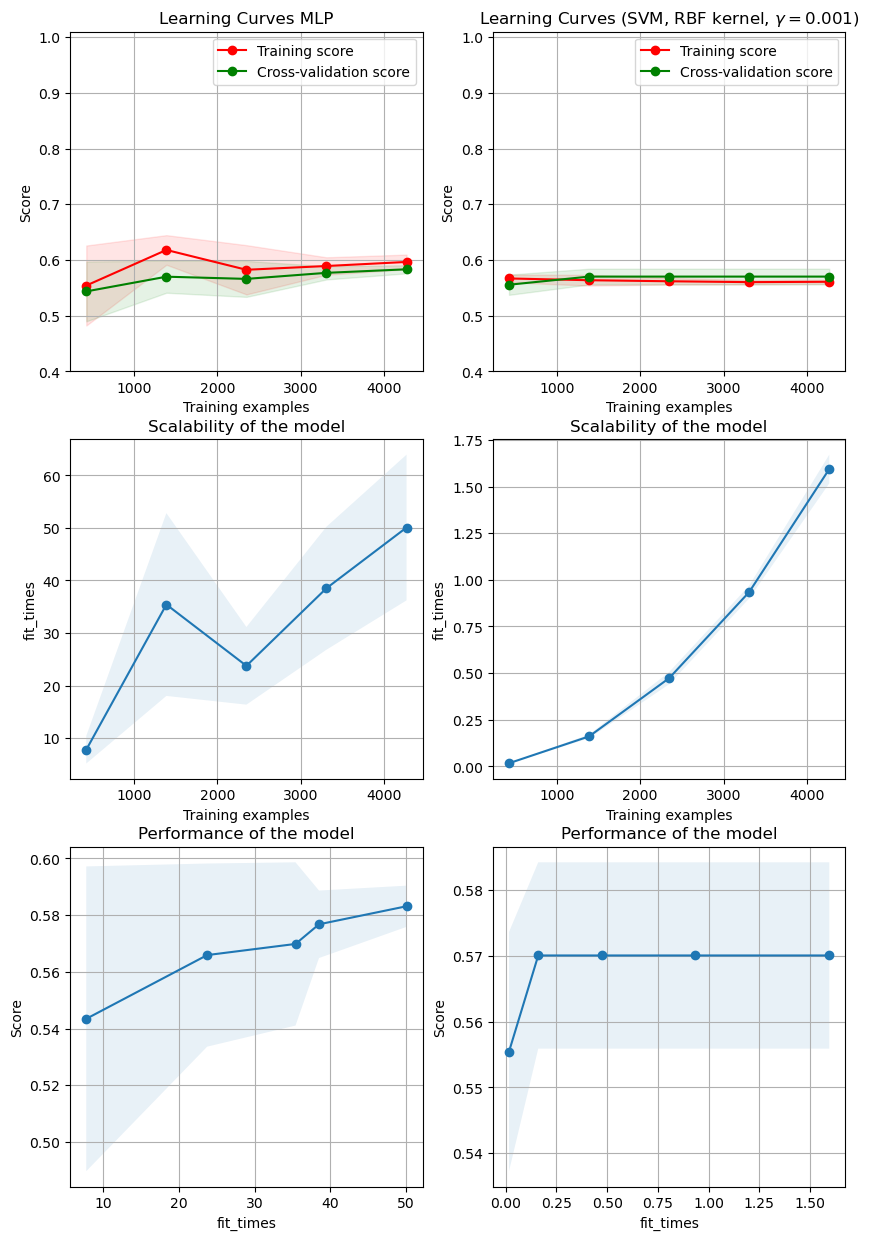

In [371]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves MLP"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

X = Xde
y = y

estimator = MLPClassifier(hidden_layer_sizes=(512, 512), max_iter=600)
plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=axes[:, 0],
    ylim=(0.4, 1.01),
    cv=cv,
    n_jobs=6,
    scoring="accuracy",
)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.4, 1.01), cv=cv, n_jobs=4
)

plt.show()

<AxesSubplot:>

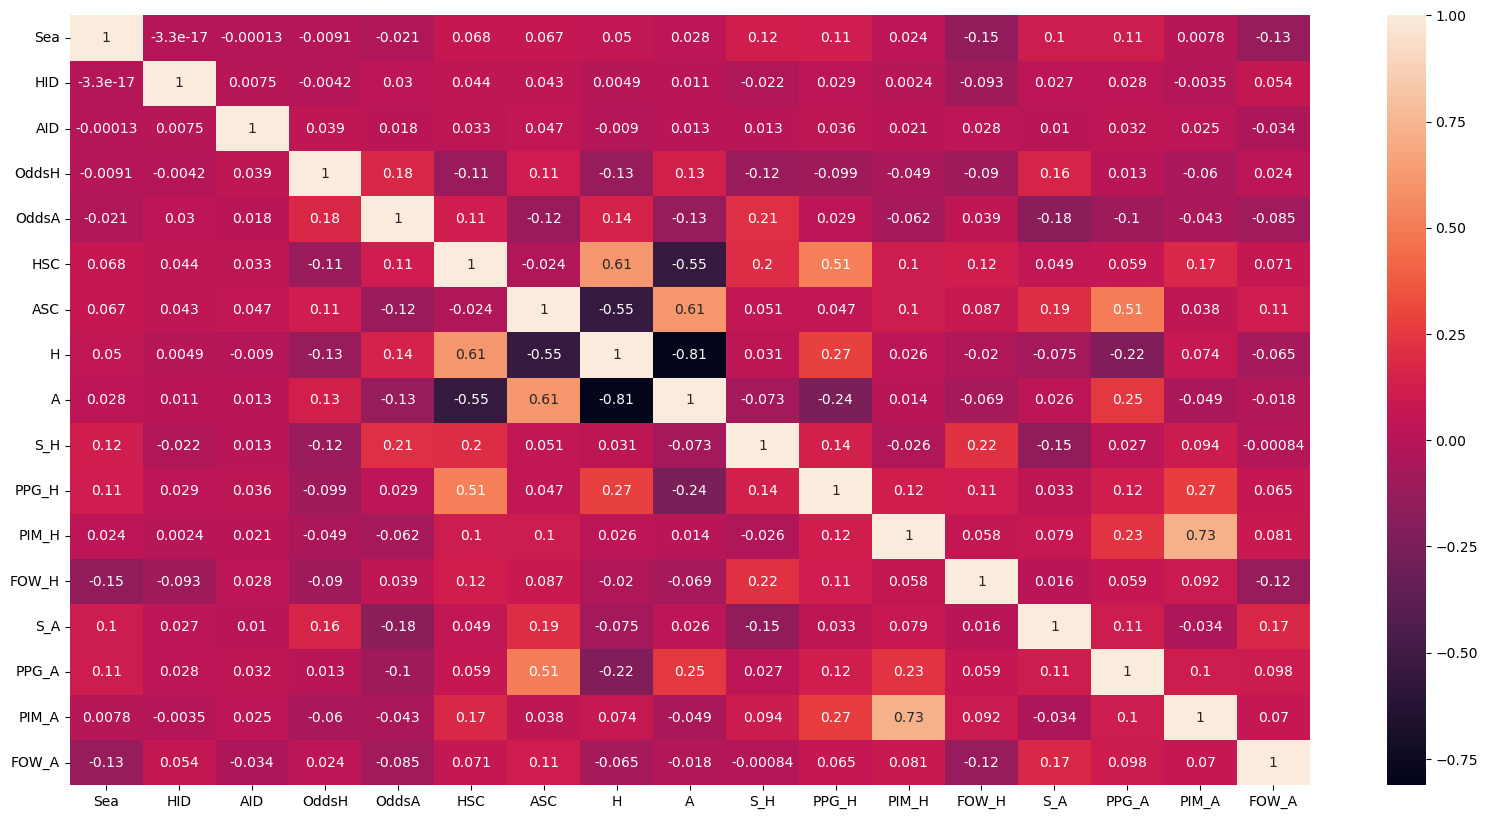

In [374]:
import seaborn as sns
plt.figure(figsize=(20,10)) 
sns.heatmap(dataset.corr(), annot= True)

In [437]:
import xgboost as xgb

In [510]:
xgb_sk = [("poly", sklearn.preprocessing.PolynomialFeatures(2)),
          ("xgb",  xgb.XGBClassifier(objective="binary:logistic")),
         #("mlp", MLPClassifier(hidden_layer_sizes=(512,))),
                ]
int_columns = np.all(Xde.astype(int) == Xde, axis=0)

xg_c = sklearn.pipeline.Pipeline([
    ("preprocess", sklearn.compose.ColumnTransformer([
        ("onehot", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"), int_columns),
        ("scaler", sklearn.preprocessing.StandardScaler(), ~int_columns),
    ]))
] + xgb_sk)

In [511]:
xg_c.fit(train_dataDE, train_targetDE)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])),
                                                 ('scaler', StandardScaler(),
                                                  array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  Tr...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                    

In [512]:
np.sum(xg_c.predict(test_dataDE) == test_targetDE) / len(test_targetDE)

0.5711610486891385

In [513]:
np.sum(xg_c.predict(train_dataDE) == train_targetDE) / len(train_targetDE)

0.9411902530459232

In [514]:
param_grid = {
    "xgb__max_depth": [1, 2, 3],
    "xgb__learning_rate": [0.003, 0.01, 0.001],
    "xgb__gamma": [0.2, 0.25, 0.3],
    "xgb__reg_lambda": [0, 0.1],
    "xgb__scale_pos_weight": [0.5, 1, 1.5],
    "xgb__subsample": [0.8],
    "xgb__colsample_bytree": [0.5, 0.6, 0.7],
}

In [515]:
from sklearn.model_selection import GridSearchCV

# Init classifier
#xgb_cl = xgb.XGBClassifier(objective="multi:softprob")

# Init Grid Search
grid_cv = GridSearchCV(xg_c, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(train_dataDE, train_targetDE)

In [504]:
train_targetDE

array([0, 0, 1, ..., 1, 0, 1])

In [505]:
np.sum(grid_cv.predict(train_dataDE) == train_targetDE) / len(train_targetDE)

0.5700562324273665

In [516]:
np.sum(grid_cv.predict(test_dataDE) == test_targetDE) / len(test_targetDE)

0.5842696629213483

In [517]:
grid_cv.best_params_

{'xgb__colsample_bytree': 0.5,
 'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 2,
 'xgb__reg_lambda': 0.1,
 'xgb__scale_pos_weight': 0.5,
 'xgb__subsample': 0.8}

In [519]:
model = sklearn.pipeline.Pipeline([
                ("preprocess", sklearn.compose.ColumnTransformer([
                ("onehot",
                sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"),
                int_columns),
                ("scaler", sklearn.preprocessing.RobustScaler(), ~int_columns),
            ])),
                ('lr2', LogisticRegression(random_state=42, max_iter=1000))
            ]
        )

In [523]:
param_grid = {
    "lr2__C": [0.001, 0.003, 0.01, 0.1,0.5,1,2],
}

grid_cv = GridSearchCV(model, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(train_dataDE, train_targetDE)

In [524]:
np.sum(grid_cv.predict(test_dataDE) == test_targetDE) / len(test_targetDE)

0.6161048689138576

In [525]:
grid_cv.best_params_

{'lr2__C': 0.01}

In [24]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear = nn.Linear(28*28, 10)
    def forward(self, x):
        out = self.linear(x)
        return out

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print(model)

MLP(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
